In [1]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import networkx as nx
from typing import Literal
import utils
import wandb
import copy

from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
import torch_geometric.transforms as T

importlib.reload(utils)
importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

In [9]:
batch_size = 1

learning_rate_gnn = 0.001        #0.001 on ADAM
epochs_gnn = 1000
early_stopping = 500
dropout = 0.1

loss = nn.CrossEntropyLoss()           # cross entropy loss?!

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'Tree-Grid'] = 'Tree-Grid'

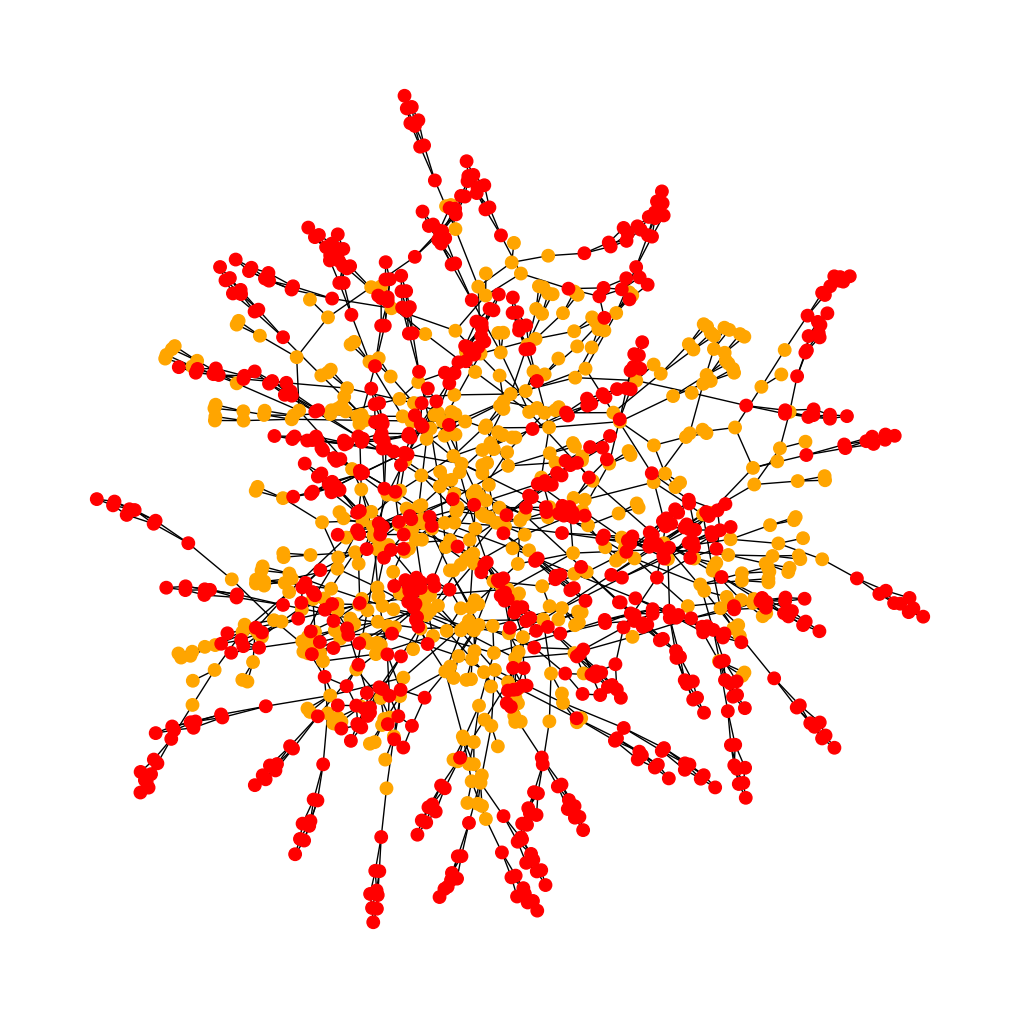

In [10]:
data, labels = datasetLoader.loadOriginalNodeDataset(datasetName)
pos = utils.plotGraphAll(data, save_path=f"{datasetName}-VIS.pdf")

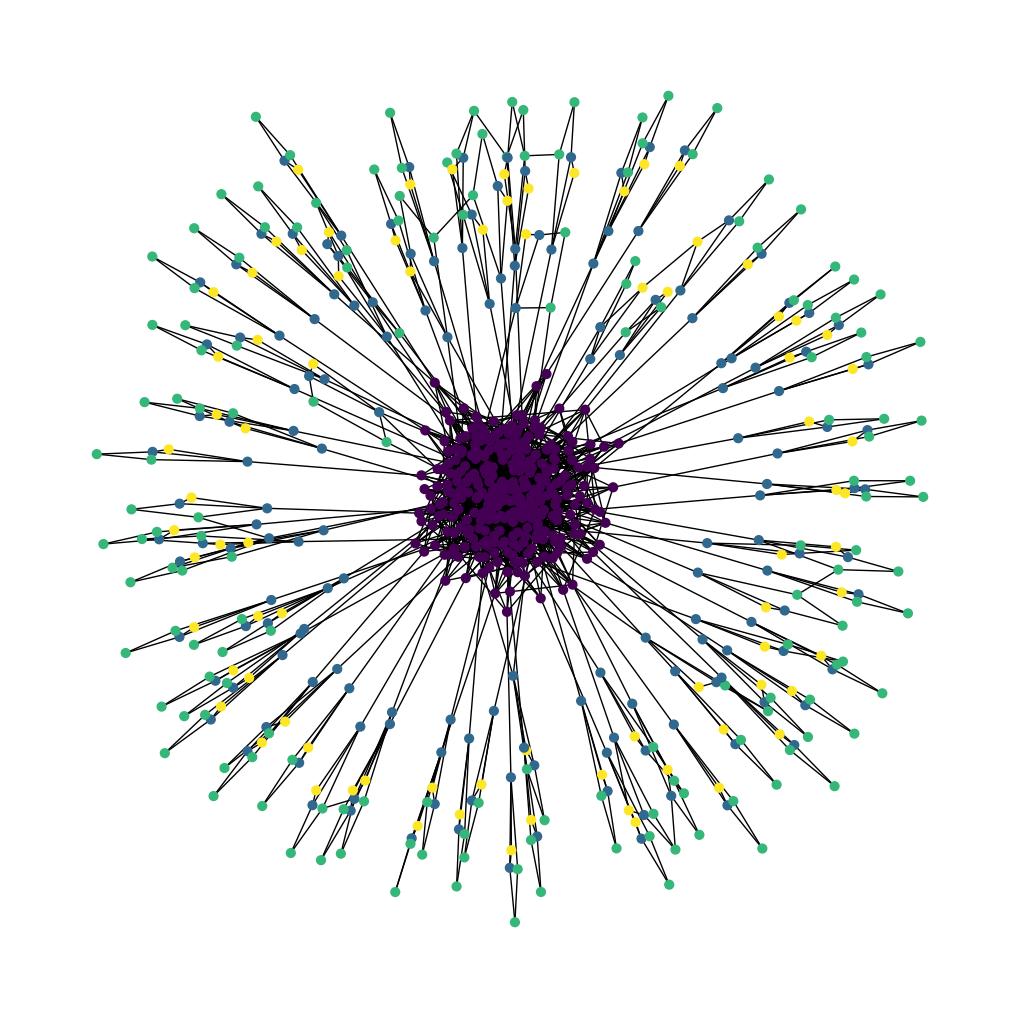

In [12]:
#labels, data = datasetLoader.loadNodeDataset(datasetName)
data, labels = datasetLoader.loadOriginalNodeDataset(datasetName)
colors = []

for i, j in enumerate(data.y):
    colors.append([j.item()])

g = torch_geometric.utils.to_networkx(data, to_undirected=True)

pos = nx.spring_layout(g, seed=42)          # try kamada_kawai_layout
plt.figure(figsize=(10, 10))  # You can adjust the size as needed

nx.draw(g, pos, node_size=40,font_size=8, node_color = colors)

In [107]:
print(data.x)

print(labels)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
{'BA-Shapes': 4, 'BA-Community': 8, 'Tree-Cycles': 2, 'Tree-Grid': 2}


In [4]:
print(data)
print(data.edge_index.shape)
print(data.y)
print(data)

train_data_y = data.y[data.train_mask]
print(train_data_y.shape)

train_data = data.subgraph(data.train_mask)
print(train_data)
print(len(train_data.y))

print(len(data.y[data.train_mask]))
print(data.x.shape)
print(data.x)

Explanation(edge_index=[2, 1630], y=[991], edge_mask=[1630], node_mask=[991], x=[991, 10], train_mask=[991], val_mask=[991], test_mask=[991])
torch.Size([2, 1630])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
gnn = networks.NodeGNN(features = data.x.shape[1], labels=labels, dropout=dropout)       # temp.y.shape[0] is wrong!!! TODO: how do I get #labels from loader?? take from loader.dataset? Store with dataset

gnn_optimizer = torch.optim.Adam(params = gnn.parameters(), lr = learning_rate_gnn)

print(f"Training on Graph with {len(data.y)} nodes")

train_mask = data.train_mask

early_stop_counter = 0
min_val_loss = 1000.0
best_val_acc = 0
best_epoch = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

params = {
    "learning_rate": learning_rate_gnn,
    "epochs": epochs_gnn,
    "batch_size": batch_size,
    "dataset_name": datasetName,
    "early_stopping": early_stopping
}

wandb.init(project="GNN training", config=params)

for epoch in range(0, epochs_gnn) :
    print(f'\n------------------ EPOCH {epoch + 1} -------------------')

    gnn.train()

    train_acc_sum = 0
    num_batches = 1.0
    train_loss = 0.0

    gnn_optimizer.zero_grad()       # Reset parameters

    # get model embeddings (node representations)?
    out = gnn.forward(data.x, data.edge_index)

    # calc cross entropy loss between real label and predicted label
    currLoss = loss(out[train_mask], data.y[train_mask])

    currLoss.backward()
        
    torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=2)    # clip gradient above 2(for ba2motfis according to reimplementation) to stop "overlearning"?

    gnn_optimizer.step()

    # predicted labels
    preds = out[train_mask].argmax(dim=1)
    train_acc_sum = torch.sum(preds == data.y[train_mask])
        
    train_loss =  currLoss.item()                    # use currLoss.item() instead of currLoss for numeric value

    final_train_acc = train_acc_sum/len(data.y[train_mask])





    gnn.eval()

    # avg loss
    print(f"average training loss: {train_loss}, training acc: {final_train_acc}")
    wandb.log({"train/loss": train_loss/num_batches, "train/acc": final_train_acc})

    train_losses.append(train_loss)
    train_accuracies.append(final_train_acc)

    val_acc, valLoss = evaluation.evaluateNodeGNN(gnn, data, data.val_mask)
    print(f"validation loss: {valLoss}, validation acc: {val_acc}")
    wandb.log({"val/loss": valLoss, "val/acc": val_acc, "train/loss": train_loss, "train/acc": final_train_acc})

    val_losses.append(valLoss)
    val_accuracies.append(val_acc)

    # TODO: early stopping
    
    if(val_acc > best_val_acc):
        best_val_acc = val_acc
        best_epoch = epoch
        # TODO: STORE MODEL CHECKPOINT HERE!
        best_model_state = copy.deepcopy(gnn.state_dict())
    if(valLoss < min_val_loss):
        min_val_loss = valLoss
        early_stop_counter = 0
        if val_acc == best_val_acc: best_model_state = copy.deepcopy(gnn.state_dict())
    elif(valLoss > min_val_loss):
        early_stop_counter += 1
        if early_stop_counter >= early_stopping:
            print("Stopping training due to early stopping threshold")
            break
        
print(f"highest validation accuracy: {best_val_acc} in epoch {best_epoch + 1}")
print("-------------Loading best model state-------------")

gnn.load_state_dict(best_model_state)
gnn.eval()
        
test_acc, testLoss = evaluation.evaluateNodeGNN(gnn, data, data.test_mask)
print(f"test loss: {testLoss}, test acc: {test_acc}")
wandb.log({"test/loss": testLoss, "test/acc": test_acc})

torch.save(gnn.state_dict(), f"models/{datasetName}")

wandb.finish()

Training on Graph with 1231 nodes



------------------ EPOCH 1 -------------------
average training loss: 0.8239786624908447, training acc: 0.5640243887901306
validation loss: 2.1046605110168457, validation acc: 0.7154471278190613

------------------ EPOCH 2 -------------------
average training loss: 0.795957088470459, training acc: 0.5945122241973877
validation loss: 1.736385464668274, validation acc: 0.7560975551605225

------------------ EPOCH 3 -------------------
average training loss: 0.7291005849838257, training acc: 0.642276406288147
validation loss: 1.4659433364868164, validation acc: 0.7886179089546204

------------------ EPOCH 4 -------------------
average training loss: 0.7267704606056213, training acc: 0.630081295967102
validation loss: 1.2587882280349731, validation acc: 0.7886179089546204

------------------ EPOCH 5 -------------------
average training loss: 0.6957987546920776, training acc: 0.630081295967102
validation loss: 1.097385048866272, validation acc: 0.7886179089546204

------------------ EPOCH 

test/acc,▁
test/loss,▁
train/acc,▁▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████████████████
train/loss,█▇▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▇▂▁▇█▇▇▇█████████▇▇████▆███████▆████████
val/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,0.99194
test/loss,0.01549
train/acc,0.98374
train/loss,0.03242
val/acc,0.99187


### Save Model

In [50]:
torch.save(gnn.state_dict(), f"models/no_norm/Tree-Grid")

### Calculate test accuracy and loss

In [49]:
gnn.eval()

test_acc, testLoss = evaluation.evaluateNodeGNN(gnn, data, data.test_mask)
print(f"test loss: {testLoss}, test acc: {test_acc}")

test loss: 0.07997782528400421, test acc: 0.975806474685669


In [29]:
torch.set_printoptions(threshold=10_000)
print(gnn.getNodeEmbeddings(data.x, data.edge_index).detach())

tensor([[4.2540, 4.4616, 2.9143,  ..., 0.0000, 0.0000, 0.0000],
        [4.2540, 4.4616, 2.9143,  ..., 0.0000, 0.0000, 0.0000],
        [4.2540, 4.4616, 2.9143,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.2540, 4.4616, 2.9143,  ..., 0.0000, 0.0000, 0.0000],
        [4.2540, 4.4616, 2.9143,  ..., 0.0000, 0.0000, 0.0000],
        [2.5461, 2.5058, 3.0646,  ..., 0.0000, 0.0000, 0.0000]])


### Plot Losses

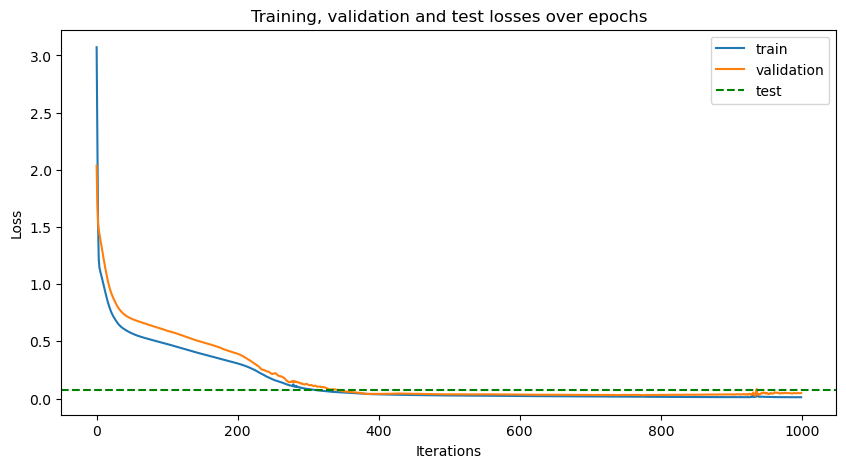

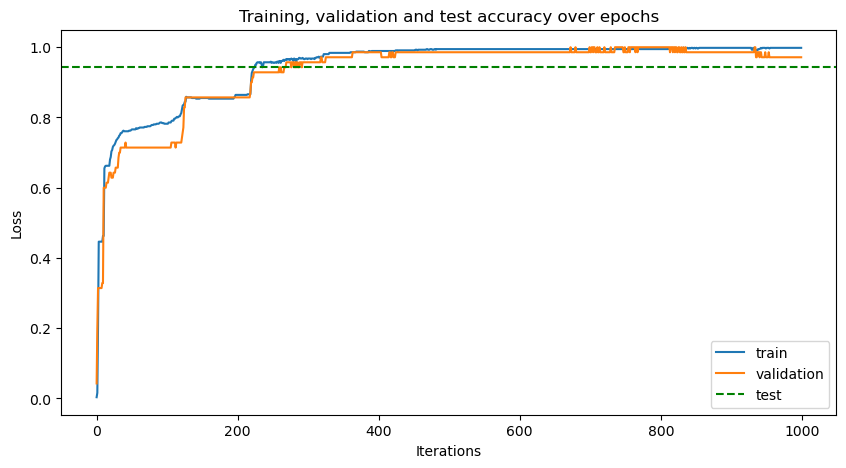

In [50]:
#   Losses
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test losses over epochs")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.axhline(y=testLoss, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#   Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test accuracy over epochs")
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.axhline(y=test_acc, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Construct a base Barabási–Albert (BA) graph.

Construct a set of five-node house-structured network motifs.

Attach the motifs to randomly selected nodes of the base graph.

Perturb the graph by adding random edges.

Nodes are assigned to 4 classes. Nodes of label 0 belong to the base BA graph. Nodes of label 1, 2, 3 are separately at the middle, bottom, or top of houses.

Generate normally distributed features of length 10

Repeat the above steps to generate another graph. Its nodes are assigned to class 4, 5, 6, 7. Its node features are generated with a distinct normal distribution.

Join the two graphs by randomly adding edges between them.

In [412]:
dataset1 = ExplainerDataset(
            graph_generator=BAGraph(300, 1),
            motif_generator=HouseMotif(),
            num_motifs=80,
            num_graphs=1,
            transform=T.Constant()      # TODO: use 2 gaussian distributions
        )
dataset2 = ExplainerDataset(
            graph_generator=BAGraph(300, 1),
            motif_generator=HouseMotif(),
            num_motifs=80,
            num_graphs=1,
            transform=T.Constant()      # TODO: use 2 gaussian distributions
        )

In [ ]:
import torch
from torch_geometric.data import Data

# Assuming graph1 and graph2 are already defined as Data objects

# Combine node features
x_combined = torch.cat([graph1.x, graph2.x], dim=0)  # Concatenate along node dimension

# Combine edge indices
edge_index_combined = torch.cat([graph1.edge_index, graph2.edge_index + graph1.num_nodes], dim=1)
# Add graph1.num_nodes to graph2's edge indices to avoid overlap

# Combine node labels (y)
y_combined = torch.cat([graph1.y, graph2.y], dim=0)

# Combine node masks
node_mask_combined = torch.cat([graph1.node_mask, graph2.node_mask], dim=0)

# Combine edge masks
edge_mask_combined = torch.cat([graph1.edge_mask, graph2.edge_mask], dim=0)

# Create a new Data object for the combined graph
combined_graph = Data(
    x=x_combined, 
    edge_index=edge_index_combined, 
    y=y_combined, 
    edge_mask=edge_mask_combined, 
    node_mask=node_mask_combined
)

# Now, combined_graph contains the merged data
